In [1]:
%pylab inline
import dfi
import dfi.fasta_convert
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import sparse
import dfi.fastaseq 
from dfi.fastaseq import mapres
from __future__ import print_function
from __future__ import division

Populating the interactive namespace from numpy and matplotlib


In [2]:
#define pdbid
pdbid = '1crm'
threashold = '0.5'

In [3]:
def calc_hessian(x,y,z,Verbose=False):
    """
    Calculate the hessian given the coordinates 
    
    Input
    -----
    (x,y,z) numpy array
       Must all be the same length
    Output
    ------
    kirchhoff: NxN numpy matrix
       
    """
    cutoff = 10
    gamma = 1
    xyz = np.column_stack((x,y,z))
    numres = xyz.shape[0]
    kirchhoff = np.zeros((numres,numres))
    for i in range(numres):
        xyz_i = xyz[i]
        i_p1 = i + 1
        xyz_ij = xyz[i_p1:] - xyz_i
        xyz_ij2=np.multiply(xyz_ij,xyz_ij)
        cutoff2 = cutoff * cutoff
        for j, dist2 in enumerate(xyz_ij2.sum(1)):
            if dist2 > cutoff2:
                continue
            if Verbose:
                print(j, dist2)
            j += i_p1
            kirchhoff[i,j] = -gamma 
            kirchhoff[j,i] = -gamma 
            kirchhoff[i,i] += gamma 
            kirchhoff[j,j] += gamma
    return kirchhoff

In [4]:
# Invert this matrix
def invert_kirchhoff(kirchhoff):
    """
    Invert matrix 
    """
    from scipy import linalg as LA
    U, w, Vt = LA.svd(kirchhoff,full_matrices=False)
    S = LA.diagsvd(w,len(w),len(w))
    np.allclose(kirchhoff,np.dot(U,np.dot(S,Vt)))
    tol = 1e-6
    singular = w < tol
    assert np.sum(singular) == 1.
    invw = 1/w
    invw[singular] = 0
    inv_kirchhoff = np.dot(np.dot(U,np.diag(invw)),Vt)
    return inv_kirchhoff

###Use EC from EVfold to generate kirchhoff

In [5]:
def _build_kirchhoff(evod_file,n):
    """
    Creates a kirchoff matrix using EVfold contacts
    Input
    -----
    evfold input file: str
       file from evfold
    n: size of the square matrix
    Output
    ------
    kirchoff: NxN numpy matrix
       output matrix
    """

    chain = []
    chain_connection = np.zeros((n,n))
    
    #assign a -1 for residues in contact in the chain
    for i in range(3, n-3):
        #beginning of chain
        chain_connection[i-3, i-2] = -1
        chain_connection[i-3, i-1] = -1
        chain_connection[i-2, i-3] = -1
        chain_connection[i-2, i-1] = -1
        chain_connection[i-1, i-2] = -1
        chain_connection[i-1, i-3] = -1
        
        
        #end of chain
        chain_connection[i+3, i+2] = -1
        chain_connection[i+3, i+1] = -1
        chain_connection[i+2, i+3] = -1
        chain_connection[i+2, i+1] = -1
        chain_connection[i+1, i+2] = -1
        chain_connection[i+1, i+3] = -1
        
        #middle of chain
        chain_connection[i, i+1] = -1
        chain_connection[i, i+2] = -1
        chain_connection[i, i+3] = -1
        chain_connection[i+1, i] = -1
        chain_connection[i+2, i] = -1
        chain_connection[i+3, i] = -1
        chain_connection[i, i-1] = -1
        chain_connection[i, i-2] = -1
        chain_connection[i, i-3] = -1
        chain_connection[i-1, i] = -1
        chain_connection[i-2, i] = -1
        chain_connection[i-3, i] = -1
        
        #middle of chain
        chain.append([i, i+1, chain_connection[i, i+1]])
        chain.append([i, i+2, chain_connection[i, i+2]])
        chain.append([i, i+3, chain_connection[i, i+3]])
        chain.append([i+1, i, chain_connection[i+1, i]])
        chain.append([i+2, i, chain_connection[i+2, i]])
        chain.append([i+3, i, chain_connection[i+3, i]])
        chain.append([i, i-1, chain_connection[i, i-1]])
        chain.append([i, i-2, chain_connection[i, i-2]])
        chain.append([i, i-3, chain_connection[i, i-3]])
        chain.append([i-1, i, chain_connection[i-1, i]])
        chain.append([i-2, i, chain_connection[i-2, i]])
        chain.append([i-3, i, chain_connection[i-3, i]])
        
        #beginning of chain
        chain.append([i-3, i-2, chain_connection[i-3, i-2]])
        chain.append([i-3, i-1, chain_connection[i-3, i-1]])
        chain.append([i-2, i-3, chain_connection[i-2, i-3]])
        chain.append([i-2, i-1, chain_connection[i-2, i-1]])
        chain.append([i-1, i-2, chain_connection[i-1, i-2]])
        chain.append([i-1, i-3, chain_connection[i-1, i-3]])
        
        #end of chain
        chain.append([i+3, i+2, chain_connection[i+3, i+2]])
        chain.append([i+3, i+1, chain_connection[i+3, i+1]])
        chain.append([i+2, i+3, chain_connection[i+2, i+3]])
        chain.append([i+2, i+1, chain_connection[i+2, i+1]])
        chain.append([i+1, i+2, chain_connection[i+1, i+2]])
        chain.append([i+1, i+3, chain_connection[i+1, i+3]])
        
    #assign a -1 for EC pairs
    
    evol = []
    evol_const = np.zeros((n,n))
    
    with open(evod_file, 'r') as file: 
        for line in file:
            continue
            a = line.split()
            i = int(a[0]) - 1 
            j = int(a[1]) - 1
            #if (i < n and j < n):
            #define threashold
            if (a[4] >= threashold):
                if (chain_connection[i, j] != -1):
                    evol_const[i, j] = -1.0*float(a[4])
                    evol_const[j, i] = -1.0*float(a[4])
                    evol.append([i, j, evol_const[i, j]])
                    evol.append([j, i, evol_const[j, i]])
    
    #build kirchoff matrix
    kirchhoff = np.zeros((n,n))
    kirchhoff = chain_connection + evol_const
    print('generated kirchhoff using evolutionary constraints')
    print('kirchhoff shape: ', kirchhoff.shape)
    
    #calculate the diagonal
    diag = []
    for i in range(0, n):
        kirchhoff[i, i] = -np.sum(kirchhoff[i])
        diag.append([i, i, kirchhoff[i, i]])
    
    #put everything together for a file
    all = chain + evol + diag

    #make the kirchhoff matrix unique
    nodupes = []
    [nodupes.append(i) for i in all if not nodupes.count(i)]   
    nodupes.sort()
    
    f = open('evfold_kirchhoff.txt', 'w')
    for x in nodupes:
        f.write('%s \t %s \t %s \n' % (x[0], x[1], x[2]))
    f.close()

    return kirchhoff;

In [6]:
#exctract top EC pairs from contactfile 

contactfile = open('contacts', 'w')
with open('contactmap.txt', 'r') as file:
    for line in file:
        if line[0].isdigit():
            contactfile.write('%s' % (line))
contactfile.close()

In [7]:
dfi.fetch_pdb('1d5r')

In [8]:
#dfi.fetch_pdb('5pnt')
#mdlpdbfile=pdbid+'.pdbmdl'
mdlpdbfile='1d5r.pdbmdl'
exptpdbfile='1d5r.pdb'
evoDfile='contactmap.txt'
#uniprotID='Q13126'

In [9]:
#PDB MODEL
ATOMS = dfi.pdbio.pdb_reader(mdlpdbfile,CAonly=True)
x,y,z = dfi.getcoords(ATOMS)
numres = len(x)
mdlseq=[mapres[atom.res_name] for atom in ATOMS]
kirchhoff = calc_hessian(x,y,z)
inv_kirchhoff = invert_kirchhoff(kirchhoff)
mdl_diag = np.array([inv_kirchhoff[i,i] for i in range(numres)])
pdblen=len(mdlseq)
print(pdblen)

Read 307 atoms from the 1d5r.pdbmdl
307


In [10]:
#Experimental PDB 
expt_ATOM = dfi.pdbio.pdb_reader(exptpdbfile,CAonly=True)
expt_betafactors = np.array([atom.temp_factor for atom in expt_ATOM])
exptseq=[mapres[atom.res_name] for atom in expt_ATOM]

Read 307 atoms from the 1d5r.pdb


In [11]:
print(exptseq)

['R', 'R', 'Y', 'Q', 'E', 'D', 'G', 'F', 'D', 'L', 'D', 'L', 'T', 'Y', 'I', 'Y', 'P', 'N', 'I', 'I', 'A', 'M', 'G', 'F', 'P', 'A', 'E', 'R', 'L', 'E', 'G', 'V', 'Y', 'R', 'N', 'N', 'I', 'D', 'D', 'V', 'V', 'R', 'F', 'L', 'D', 'S', 'K', 'H', 'K', 'N', 'H', 'Y', 'K', 'I', 'Y', 'N', 'L', 'C', 'A', 'E', 'R', 'H', 'Y', 'D', 'T', 'A', 'K', 'F', 'N', 'C', 'R', 'V', 'A', 'Q', 'Y', 'P', 'F', 'E', 'D', 'H', 'N', 'P', 'P', 'Q', 'L', 'E', 'L', 'I', 'K', 'P', 'F', 'C', 'E', 'D', 'L', 'D', 'Q', 'W', 'L', 'S', 'E', 'D', 'D', 'N', 'H', 'V', 'A', 'A', 'I', 'H', 'C', 'K', 'A', 'G', 'K', 'G', 'R', 'T', 'G', 'V', 'M', 'I', 'C', 'A', 'Y', 'L', 'L', 'H', 'R', 'G', 'K', 'F', 'L', 'K', 'A', 'Q', 'E', 'A', 'L', 'D', 'F', 'Y', 'G', 'E', 'V', 'R', 'T', 'R', 'D', 'K', 'K', 'G', 'V', 'T', 'I', 'P', 'S', 'Q', 'R', 'R', 'Y', 'V', 'Y', 'Y', 'Y', 'S', 'Y', 'L', 'L', 'K', 'N', 'H', 'L', 'D', 'Y', 'R', 'P', 'V', 'A', 'L', 'L', 'F', 'H', 'K', 'M', 'M', 'F', 'E', 'T', 'I', 'P', 'M', 'F', 'S', 'G', 'G', 'T', 'C', 'N', 'P',

In [12]:
#EVFOLD Contacts 
#str_seq=''.join( dfi.fastaseq.get_fastaseq(uniprotID).split('\n')[1:] )
#fastaseq=[s for s in str_seq]
numseq = len(mdlseq)
evodkirchhoff=_build_kirchhoff(evoDfile,numseq)
inv_evodkirchhoff=invert_kirchhoff(evodkirchhoff)
evo_diag = np.array([inv_evodkirchhoff[i,i] for i in range(numseq)])

generated kirchhoff using evolutionary constraints
kirchhoff shape:  (307, 307)


# Need to align sequences properly

## Grab the 5pnt fasta sequence 

In [13]:
mdl_diag.shape

(307,)

In [14]:
#print(len(fastaseq))
print(len(mdlseq))
print(len(exptseq))

307
307


In [15]:
align={'mdlseq':''.join(mdlseq),
       'exptseq':''.join(exptseq)}

In [16]:
from clustalo import clustalo

In [17]:
aligned=clustalo(align,seqtype=3)

In [18]:
dft = pd.DataFrame()

In [19]:
aligned

{'exptseq': 'RRYQEDGFDLDLTYIYPNIIAMGFPAERLEGVYRNNIDDVVRFLDSKHKNHYKIYNLCAERHYDTAKFNCRVAQYPFEDHNPPQLELIKPFCEDLDQWLSEDDNHVAAIHCKAGKGRTGVMICAYLLHRGKFLKAQEALDFYGEVRTRDKKGVTIPSQRRYVYYYSYLLKNHLDYRPVALLFHKMMFETIPMFSGGTCNPQFVVCQLKVKIYSSNSGPTRREDKFMYFEFPQPLPVCGDIKVEFFHKQNKMLKKDKMFHFWVNTFFIPKEYLVLTLTKNDLDKANKDKANRYFSPNFKVKLYFTKTV',
 'mdlseq': 'RRYQEDGFDLDLTYIYPNIIAMGFPAERLEGVYRNNIDDVVRFLDSKHKNHYKIYNLCAERHYDTAKFNCRVAQYPFEDHNPPQLELIKPFCEDLDQWLSEDDNHVAAIHCKAGKGRTGVMICAYLLHRGKFLKAQEALDFYGEVRTRDKKGVTIPSQRRYVYYYSYLLKNHLDYRPVALLFHKMMFETIPMFSGGTCNPQFVVCQLKVKIYSSNSGPTRREDKFMYFEFPQPLPVCGDIKVEFFHKQNKMLKKDKMFHFWVNTFFIPKEYLVLTLTKNDLDKANKDKANRYFSPNFKVKLYFTKTV'}

In [20]:
dft['raptor_R'] = [s for s in aligned['mdlseq']]
dft['mdl_R'] = [s for s in aligned['mdlseq']]
dft['expt_R'] = [s for s in aligned['exptseq']]

In [21]:
dft

,raptor_R,mdl_R,expt_R
0,R,R,R
1,R,R,R
2,Y,Y,Y
3,Q,Q,Q
4,E,E,E
5,D,D,D
6,G,G,G
7,F,F,F
8,D,D,D
9,L,L,L


In [22]:
#align b-factors with the corresponding sequence 
seqtype='fastaR'
bfactype='fastaB'
evo_diag

def align_bfac(seqtype,bfactype,ls_bfac,dft):
    """
    
    """
    align_bfac = []
    i=0
    for r in dft[seqtype]:
        #print(r)
        if i >= len(ls_bfac):
            break
        if r == '-':
            align_bfac.append(np.nan)
        else:
            align_bfac.append(ls_bfac[i])
            i+=1
    while len(align_bfac) < len(dft[seqtype]):
        align_bfac.append(np.nan)

    dft[bfactype] = align_bfac

In [23]:
evo_diag.shape

(307,)

In [28]:
dft.head()

,raptor_R,mdl_R,expt_R
0,R,R,R
1,R,R,R
2,Y,Y,Y
3,Q,Q,Q
4,E,E,E


In [29]:
align_bfac('raptor_R','raptor_B',evo_diag,dft)
align_bfac('mdl_R','mdl_B',mdl_diag,dft)
align_bfac('expt_R','expt_B',expt_betafactors,dft)

In [31]:
dft

,raptor_R,mdl_R,expt_R,raptor_B,mdl_B,expt_B
0,R,R,R,7.449605,0.115443,0.0
1,R,R,R,7.325576,0.083075,0.0
2,Y,Y,Y,7.230503,0.075335,0.0
3,Q,Q,Q,7.151045,0.077186,0.0
4,E,E,E,7.080654,0.102961,0.0
5,D,D,D,7.011361,0.130772,0.0
6,G,G,G,6.942598,0.181336,0.0
7,F,F,F,6.874423,0.132298,0.0
8,D,D,D,6.806714,0.131432,0.0
9,L,L,L,6.739470,0.075553,0.0


In [32]:
dft.to_csv(exptpdbfile[0:4]+'_align.csv',index=False)

In [33]:
dft[['mdl_B', 'expt_B']].corr()

,mdl_B,expt_B
mdl_B,1.0,NaN
expt_B,NaN,NaN


In [34]:
dft.dropna().corr()

,raptor_B,mdl_B,expt_B
raptor_B,1.000000,0.187239,NaN
mdl_B,0.187239,1.000000,NaN
expt_B,NaN,NaN,NaN


In [35]:
#obtain correlation coefficients
correl = dft[[i for i in dft.columns if '_B' in i]].dropna().corr()
print(correl)
correl.to_csv(exptpdbfile[0:4]+'_corr.csv') 

          raptor_B     mdl_B  expt_B
raptor_B  1.000000  0.187239     NaN
mdl_B     0.187239  1.000000     NaN
expt_B         NaN       NaN     NaN


##Make b-factor plot

In [38]:
pdbid

'1crm'

In [37]:
#prepare data for plotting
align_csv = pdbid+'_align.csv'
corr_csv = pdbid+'_corr.csv'
df = pd.read_csv(align_csv)
cf = pd.DataFrame(pd.read_csv(corr_csv))
evfold_exp = cf.get_value(2,'EVfold_B')
evfold_mdl = cf.get_value(1, 'EVfold_B')
mdl_exp = cf.get_value(2,'mdl_B')
df = df.dropna()

#make normalized b-factors for plotting 
df['EVfold_Bnorm'] = df['EVfold_B']/df['EVfold_B'].sum()
df['mdl_Bnorm'] = df['mdl_B']/df['mdl_B'].sum()
df['expt_Bnorm'] = df['expt_B']/df['expt_B'].sum()
#for index,row in df.iterrows():
    #print row['EVfold_B']/df['EVfold_B'].sum()

IOError: File 1crm_align.csv does not exist

In [51]:
#plot the b-factors for evfold, mdl, and expt
plt.figure()  
plt.figure(figsize=(17, 6))
sns.set_style("whitegrid")
sns.set_context("poster", font_scale=2.0)
plt.plot(df['EVfold_Bnorm'], color='b', label='EVcouplings: '+str(round(evfold_exp,2))+', '+str(round(evfold_mdl,2)))
plt.plot(df['mdl_Bnorm'], color='r', label='Structure: '+str(round(mdl_exp,2)))
plt.plot(df['expt_Bnorm'], color='k', label='Experiment')
#plt.ylim(0,0.009)
#plt.xlim(0,pdblen)
plt.ylabel('B-factor')
#plt.xlabel('Residue')
plt.title('PDB: '+pdbid.upper())
plt.legend(fontsize=20, loc='upper center', ncol=3)
#plt.legend(bbox_to_anchor=(1.24, 0.8), loc='right', ncol=1, fontsize=20)
plt.tight_layout()
plt.savefig('bfactor_'+pdbid+'.png')

NameError: name 'df' is not defined

##Make contact map

NameError: name 'labels' is not defined

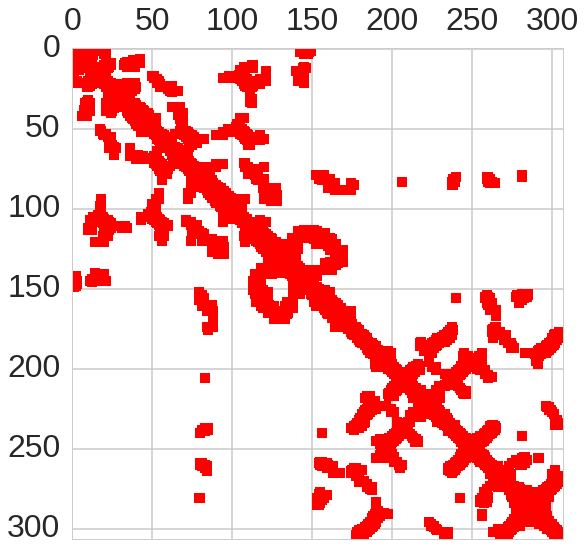

In [52]:
#structure
sB = sparse.csr_matrix(kirchhoff)
plt.spy(sB, color='r')
plt.setp(labels, rotation=90)
plt.show()

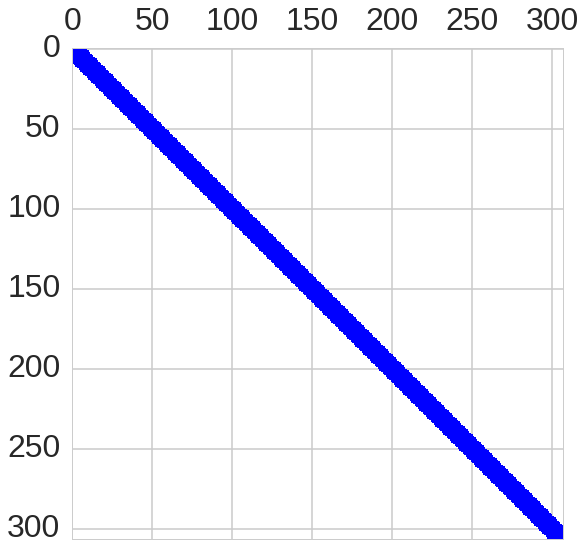

In [53]:
#evolution
sA = sparse.csr_matrix(evodkirchhoff)
plt.spy(sA, color='b')
plt.show()

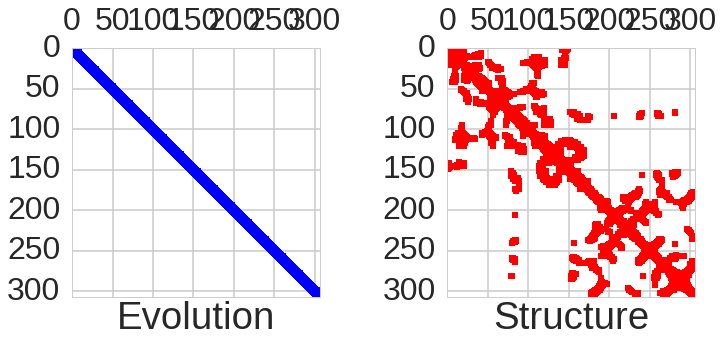

In [54]:
#combined contactmaps
fig = plt.figure()

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.spy(sA, markersize=6, color='b')
ax2.spy(sB, markersize=6, color='r')

fig.set_figheight(6)
fig.set_figwidth(11)

ax1.set_title('Evolution', y=-0.15)
ax2.set_title('Structure', y=-0.15)

plt.tight_layout()
savefig('contactmaps')

NameError: name 'df' is not defined

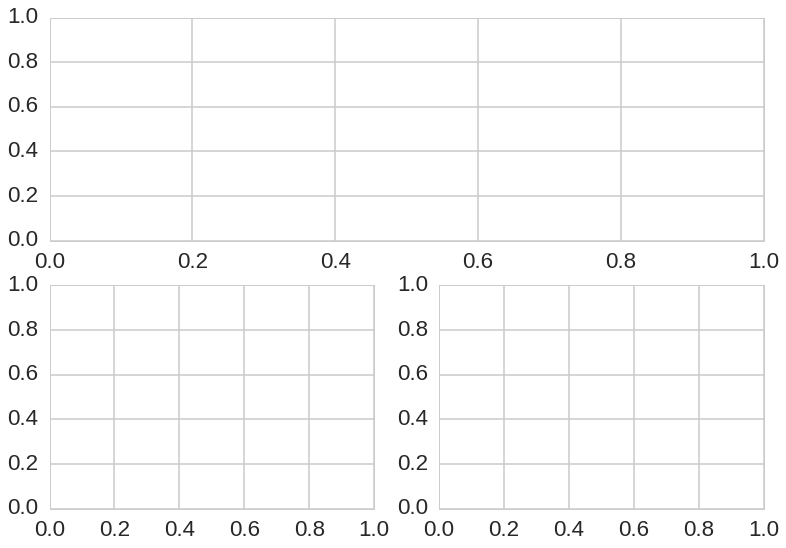

In [55]:
sns.set_style("whitegrid")
sns.set_context("poster", font_scale=1.4)

fig = plt.figure()

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(223)
ax3 = fig.add_subplot(224)

ax1.plot(df['expt_Bnorm'], color='k', linewidth=2.5, label='Experiment')
ax1.plot(df['mdl_Bnorm'], color='#FFA500', linewidth=2.5, alpha=0.5, label='Structure: '+str(round(mdl_exp,2)))
ax1.plot(df['EVfold_Bnorm'], color='#8A2BE2', linewidth=2.5, alpha=0.5, label='RaptorX: '+str(round(evfold_exp,2))+', '+str(round(evfold_mdl,2)))
ax1.set_title('PDB: '+pdbid.upper()+' (cutoff: '+threashold+')', fontsize=20)
ax1.legend(fontsize=16, loc='upper center', ncol=3)

ax2.spy(sA, markersize=6, color='#8A2BE2')
ax3.spy(sB, markersize=6, color='#FFA500')

fig.set_figheight(10)
fig.set_figwidth(11)

ax2.set_title('RaptorX', fontsize=25, y=-0.12)
ax3.set_title('Structure', fontsize=25, y=-0.12)

plt.tight_layout()
savefig(pdbid+'_combinedplots')